In [364]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [365]:
def f(x):
    return 3*x**2 - 4*x + 5

In [366]:
f(3.0)

20.0

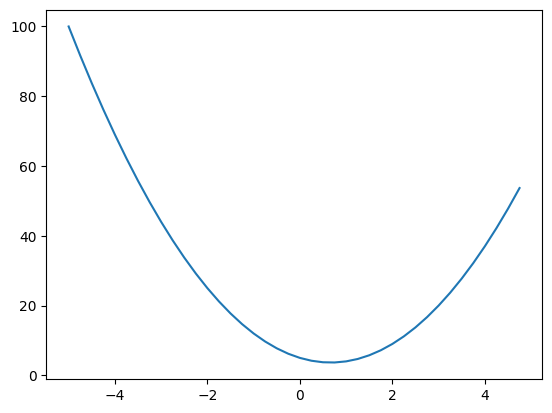

In [367]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [368]:
h = 0.00000000001
x = 2.3
(f(x+h) - f(x))/h

9.799805411603302

In [369]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [370]:
h = 0.00001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


In [479]:
class Value:
    def __init__(self,data, _children = (), _op="", _label = ''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._label = _label
        self._backward = lambda:None
        self.grad = 0.0
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other),'+')
        
        def _backward():
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        out._backward = _backward 
            
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward 
        
        return out
    
    def __pow__(self,other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data ** other.data, (self,other),'**')
        
        def _backward():
            self.grad += other.data * (self.data ** (other.data - 1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self,other):
        return self + other
    
    def __rmul__(self,other):
        return self * other
    
    def __truediv__(self,other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,),'tanh')
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
        out._backward = _backward 
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,),'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [372]:
a = Value(2.0)
b = Value(4.0)
a-b

Value(data=-2.0)

In [373]:
x1 = Value(2.0, _label='x1')
x2 = Value(0.0, _label='x2')
w1 = Value(-3.0, _label='w1')
w2 = Value(1.0, _label='w2')

b = Value(6.8813735870195432, _label='b')

x1w1 = x1 * w1; x1w1._label = 'x1w1'
x2w2 = x2 * w2; x2w2._label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n._label = 'n'

e = (2*n).exp()
o = (e - 1)/(e + 1); o._label = 'o'

o.backward()

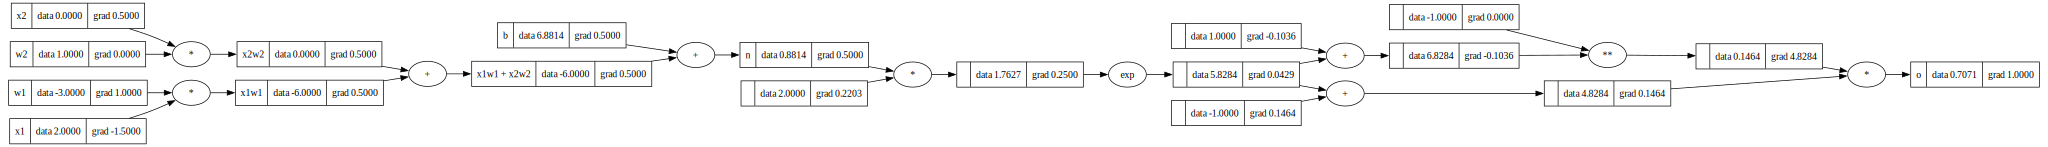

In [374]:
draw_dot(o)

In [375]:
import torch
import random


In [486]:

class Neuron:
    
    def __init__(self, nin):
        self.w =  [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        #print(list(zip(self.w,x)))
        act =  sum([wi*xi for wi,xi in zip(self.w,x)], self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin]+nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.039518049442336375)

In [487]:
n.parameters()

[Value(data=-0.41635676489364615),
 Value(data=-0.5656807337020058),
 Value(data=0.1849620713024247),
 Value(data=0.02102689893304488),
 Value(data=-0.30431001729081575),
 Value(data=-0.8049804755428316),
 Value(data=-0.8248171149206822),
 Value(data=-0.3253890857744115),
 Value(data=-0.07884142017413742),
 Value(data=0.030586857184555782),
 Value(data=-0.2126454923869432),
 Value(data=0.5375539546551664),
 Value(data=-0.4848604268005121),
 Value(data=0.8707105941056132),
 Value(data=-0.4432572310031837),
 Value(data=-0.15671523270376575),
 Value(data=-0.4213550199991005),
 Value(data=-0.07304740838058099),
 Value(data=0.30907605143166395),
 Value(data=0.42049635826918275),
 Value(data=-0.6680436473342386),
 Value(data=-0.6850541339949106),
 Value(data=0.7573866349679941),
 Value(data=0.9162054653245106),
 Value(data=-0.9045050789864248),
 Value(data=-0.5712074899674249),
 Value(data=0.481904131680462),
 Value(data=0.6084374733300819),
 Value(data=0.8359662600033284),
 Value(data=0.730

In [488]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
    
]
ys = [1.0, -1.0, -1.0, 1.0]



In [489]:
for k in range(50):
    
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.01*p.grad
        
    print(k, loss.data)

0 5.079792565837067
1 4.404320585746563
2 3.852130266881639
3 3.4024166673920413
4 3.0299833746939755
5 2.713638784639812
6 2.4380421434826256
7 2.1930210343087033
8 1.9723215585531118
9 1.7723812064183753
10 1.5912719798180714
11 1.4278744260932732
12 1.2813177251764736
13 1.1506752872224362
14 1.0348576057005445
15 0.9326244700335122
16 0.8426492442688556
17 0.7635918488166223
18 0.6941592160598853
19 0.6331465911591865
20 0.5794606386758112
21 0.5321282859052542
22 0.4902957153813515
23 0.45322130305327757
24 0.42026535631573425
25 0.39087860454575796
26 0.364590670912497
27 0.3409992290496349
28 0.31976019419161816
29 0.3005790745889149
30 0.2832034768131771
31 0.26741668713519473
32 0.2530322180815193
33 0.2398891991843085
34 0.2278484937795071
35 0.21678943316071989
36 0.20660707164365172
37 0.19720987894125971
38 0.18851779850901879
39 0.1804606116239778
40 0.17297655670092324
41 0.16601116171418465
42 0.15951625467754058
43 0.15344912307602598
44 0.14777179809399654
45 0.142450